### This notebook shows an example of doing some data preperation and using sklearn to do a regression

This needs a bit of work to match the column names to the input dataset

The usual imports

In [1]:
import os
import tables_io
import numpy as np
import matplotlib.pyplot as plt
from macss import plotting_functions
from macss import utility_functions


Change this to be the root of the current PZ working area

In [2]:
HOME = os.environ['HOME']
pz_dir = f'{HOME}/macss'

Read a test file (in this case a Roman / Rubin open universe sim)

In [3]:
d = tables_io.read(f"{pz_dir}/data/roman_rubin_9925.hdf5")

In [4]:
d.keys()

odict_keys(['LSST_obs_g', 'LSST_obs_g_err', 'LSST_obs_i', 'LSST_obs_i_err', 'LSST_obs_r', 'LSST_obs_r_err', 'LSST_obs_u', 'LSST_obs_u_err', 'LSST_obs_y', 'LSST_obs_y_err', 'LSST_obs_z', 'LSST_obs_z_err', 'ROMAN_obs_F184', 'ROMAN_obs_H158', 'ROMAN_obs_J129', 'ROMAN_obs_K213', 'ROMAN_obs_R062', 'ROMAN_obs_W146', 'ROMAN_obs_Y106', 'ROMAN_obs_Z087', '_orientationAngle', 'bulge_frac', 'dec', 'diskHalfLightRadiusArcsec', 'galaxy_id', 'mag_g_lsst', 'mag_i_lsst', 'mag_r_lsst', 'mag_u_lsst', 'mag_y_lsst', 'mag_z_lsst', 'major', 'minor', 'orientationAngle', 'ra', 'redshift', 'spheroidHalfLightRadiusArcsec', 'totalEllipticity', 'totalEllipticity1', 'totalEllipticity2', 'totalHalfLightRadiusArcsec'])

Split it in half into training and test sets

In [5]:
train = tables_io.sliceObj(d, slice(0, -1, 2))
test = tables_io.sliceObj(d, slice(1, -1, 2))

Set up a regression algorithm

In [6]:
from sklearn.ensemble import HistGradientBoostingRegressor

In [7]:
reg = HistGradientBoostingRegressor(max_iter=5000)

Extract targets (specz redshfits) and features (color and magnitudes) from the data

In [8]:
train_targets, train_features = utility_functions.prepare_data_total_mag_and_colors(train, 'LSST_obs_{band}', 'ugrizy')
test_targets, test_features = utility_functions.prepare_data_total_mag_and_colors(test, 'LSST_obs_{band}', 'ugrizy')

Do some data preparation, scaling the inputs

In [9]:
from sklearn import preprocessing

In [10]:
scaler = preprocessing.StandardScaler().fit(train_features)

In [11]:
scaler.transform(train_features)

array([[-0.11473128, -0.27918152, -0.88099549,  0.05426437,  0.42913138,
        -0.17307951],
       [ 0.85788801,  0.01321881, -0.91226196,  0.08414764,  1.08974739,
        -1.22235985],
       [ 0.24353051, -0.50627191, -0.87396092,  0.13126027,  1.09747126,
         0.58093198],
       ...,
       [ 0.42931408, -0.05904954, -0.65715199,  0.29558914,  0.51478644,
        -1.63630772],
       [-0.05504769, -0.9643298 ,  1.14638474,  1.80695871,  1.45472433,
         0.69437813],
       [-0.1824171 ,  0.62221399,  1.56039469,  2.17625553,  1.8071096 ,
         0.3494299 ]], shape=(256887, 6))

In [12]:
scaled = scaler.transform(train_features).clip(-5, 5)

In [13]:
train_features[0:,0].min()

np.float64(13.121183843089646)

In [14]:
train_features.shape

(256887, 6)

In [15]:
# from sklearn.cluster import DBSCAN

# db = DBSCAN(eps=0.3, min_samples=10)
# db.fit(train_features)

In [16]:
# labels = np.array(db.labels_)

In [17]:
# np.bincount(labels+1)

Ok, let's PCA this sh*t

In [18]:
from sklearn.decomposition import PCA

In [19]:
pca = PCA(n_components=scaled.shape[-1], whiten=False)

In [20]:
pca.fit(scaled.clip(-5, 5))

,n_components,6
,copy,True
,whiten,False
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10
,power_iteration_normalizer,'auto'
,random_state,None


In [21]:
pca.explained_variance_ratio_

array([0.42655718, 0.18961916, 0.14485929, 0.10976067, 0.08549097,
       0.04371273])

In [22]:
pca_out = pca.transform(scaled)

Ok, let's make some featue plots...

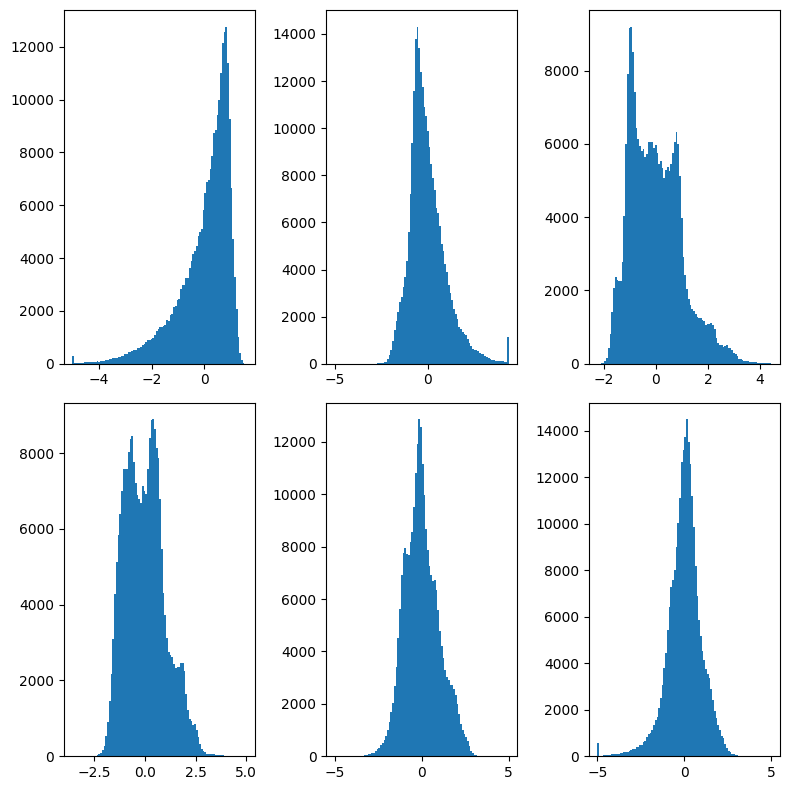

In [23]:
fig = plotting_functions.plot_feature_histograms(scaled)

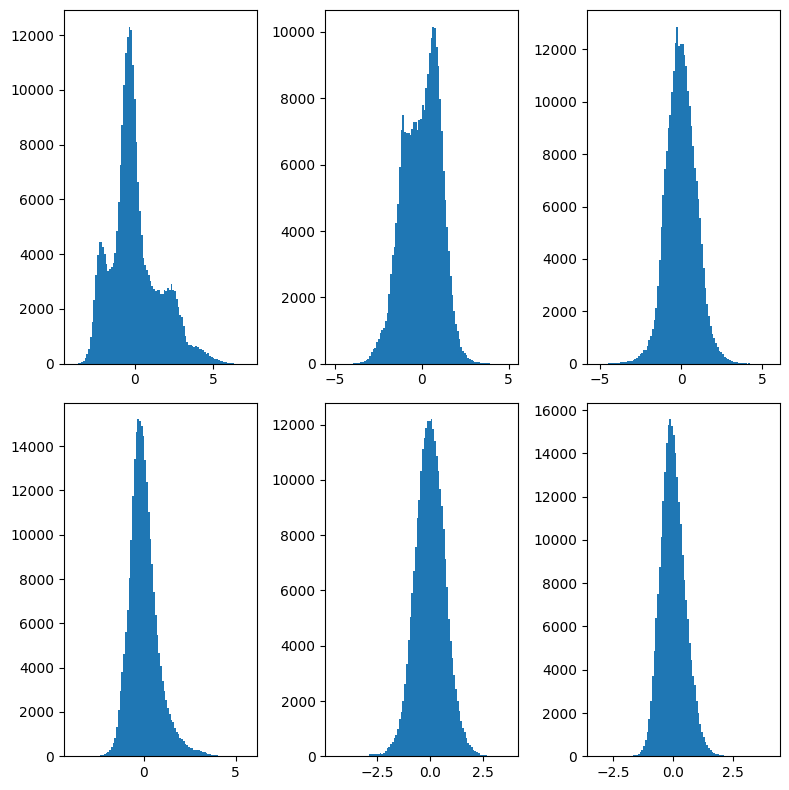

In [24]:
fig = plotting_functions.plot_feature_histograms(pca_out)

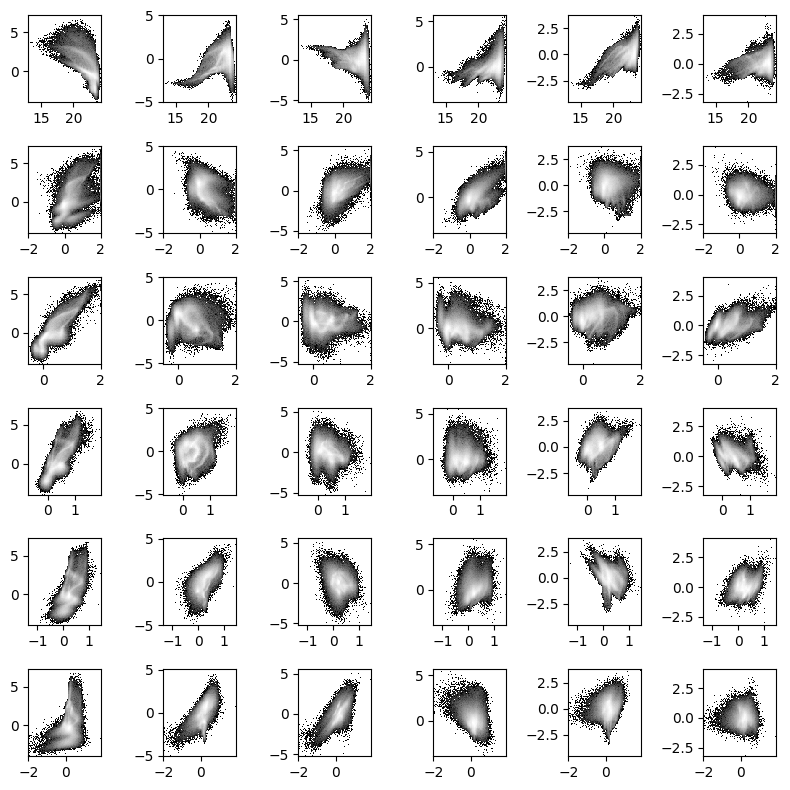

In [25]:
_ = plotting_functions.plot_pca_hist2d(train_features, pca_out)

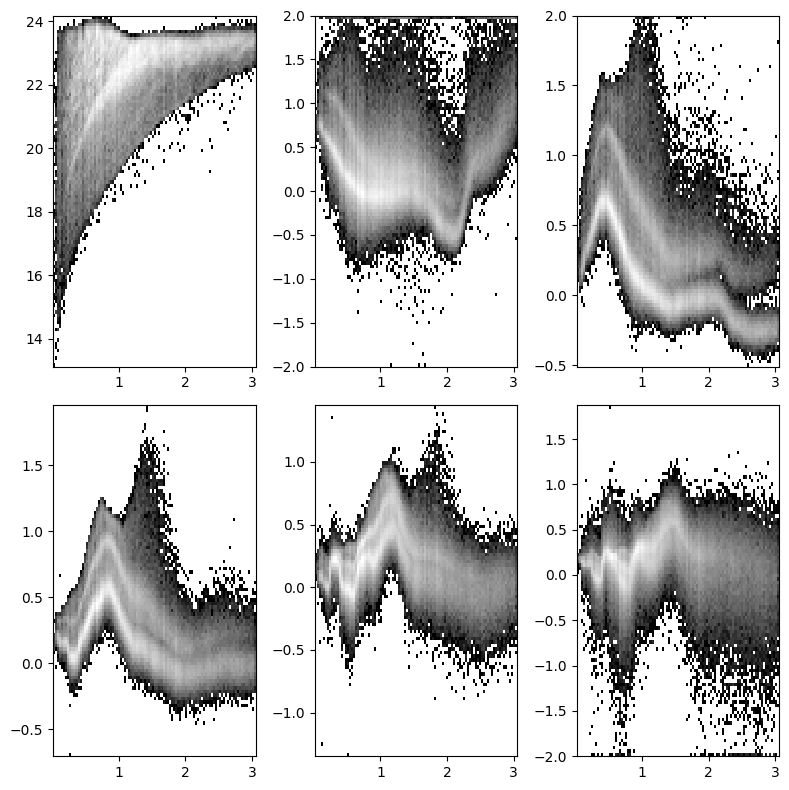

In [26]:
_ = plotting_functions.plot_feature_target_hist2d(train_features, train_targets)

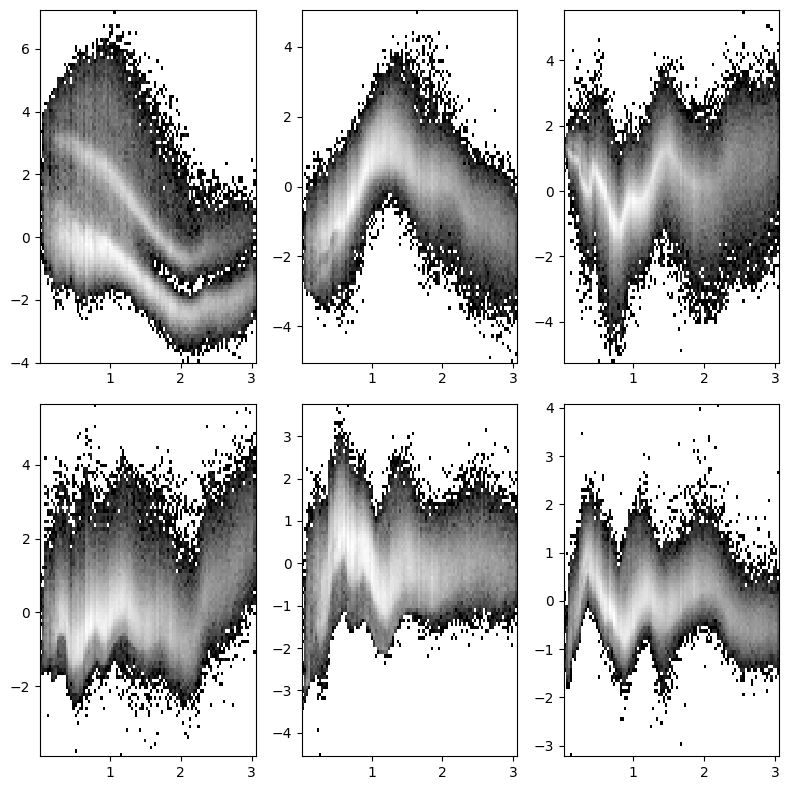

In [27]:
_ = plotting_functions.plot_feature_target_hist2d(pca_out, train_targets)

In [28]:
# _ = plotting_functions.plot_features_target_scatter(pca_out, train_targets)

Run an example regression

In [29]:
preds = utility_functions.run_regression(reg, train_features, train_targets, test_features)

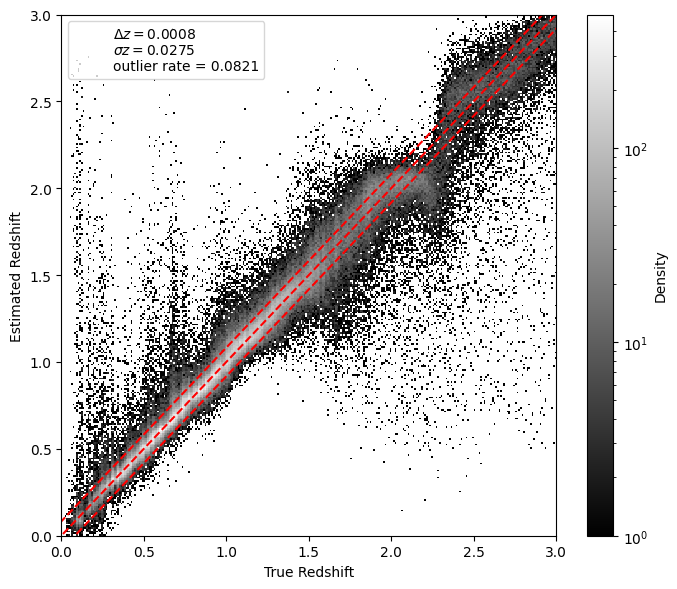

In [30]:
_ = plotting_functions.plot_true_predict_fancy(test_targets, preds)